# Clasificación plana con una capa oculta

Hemos visto como counstruir un elemento básico de una red neuronal, sin embargo es tiempo de ir un poco mas lejos y entender el flujo de información en las capas ocultas de las redes neuronales. Para ello construiremos una red neuronal propiamente diche con una capa oculta. Veremos grandes diferencias entre esta nueva implementación y la vista anteriormente.

**Objetivos de Aprendizaje:**
- Implementar un clasificador de 2 clases implementando una red neuronal con una única capa oculta.
- Usar una función de activación no linear, en este caso tanh.
- Realizar el cómputo de la perdida de entropia crzada.
- Implementar la propagación de la información en ambas direcciones. Es decir propagación hacia adelante y retropropagación.


## 1 - Paquetes a utilizar ##

Importamos los paquetes que necesitamos para este ejercicio.
- [numpy](www.numpy.org) es el paquete fundamental para realizar computación científica con Python.
- [sklearn](http://scikit-learn.org/stable/) provee herramientas para el manejo y el análisis de datos.
- [matplotlib](http://matplotlib.org) Librería de gráficos en Python.
- testCases provee algunos ejemplos de testeo para asegurarnos de la viabilidad de las funciones.
- planar_utils provee algunas funciones de ayuda para este ejercicio.

In [3]:
# Importación de los Paquetes.
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # setea una semilla (seed) para que los resultados de la generación aleatoria sean consistentes

## 2 - Dataset ##

Ahora exploraremos el set de datos con el que trabajaremos. EL siguiente código cargará un dataset "flower" de dos clases en el ambiente de trabajo a las variables `X` e `Y`.

In [4]:
X, Y = load_planar_dataset()

Haciendo uso de la librería matplotlib, podemos visualizar los datos que recien hemos cargado. Los datos se ven como una "flor" con algunos puntos rojos (etiqueta y = 0) y algunos puntos azules (etiqueta y = 1). El objetivo es construir un modelo que logre ajustarse a estos datos.

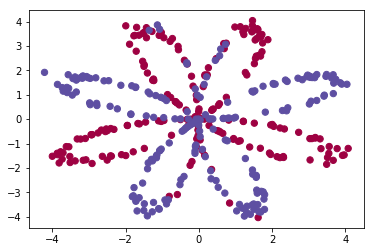

In [5]:
# Visualizamos los datos:
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral);

Tenemos:
    - un arreglo de numpy (matriz) X que contiene las carácteristicas o entradas (x1, x2)
    - un arreglo de numpy (vector) Y que contiene las etiquetas (rojo:0, azul:1).

Es importante ahora tener una mejor percepcion de como son nuestros datos.

**Ejercicio**: Cuantos ejemplos de entrenamiento tenemos?, Cual es la forma de las variables `X` e `Y`?

**Pista**: Como obtener la forma de un arreglo de numpy? [(help)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [6]:
### Empezar Código acá ### (≈ 3 lines of code)
shape_X = 
shape_Y = 
m =   # tamaño del set de entrenamiento.
### Código hasta acá ###

print ('La forma de X es: ' + str(shape_X))
print ('La forma de Y is: ' + str(shape_Y))
print ('Se tienen m = %d ejemplos de entrenamiento!' % (m))

La forma de X es: (2, 400)
La forma de Y is: (1, 400)
Se tienen m = 400 ejemplos de entrenamiento!


**Salida Esperada**:
       
<table style="width:20%">
  
  <tr>
    <td>**Forma de X**</td>
    <td> (2, 400) </td> 
  </tr>
  
  <tr>
    <td>**Forma de Y**</td>
    <td>(1, 400) </td> 
  </tr>
  
    <tr>
    <td>**m**</td>
    <td> 400 </td> 
  </tr>
  
</table>

## 3 - Regresión Logística Simple.

Antes de construir una red neuronal propiamente dicha, veremos como la regresión logística se desempeña en este problema en particular.

Para ello haremos uso de la librería sklearn, que nos permitirá hacerlo de manera rápida usando sus funciones predefinidas. El código de la celda de abajo entrenará un clasificador de regresión logística con el dataset que previamente hemos explorado.

In [62]:
# Entrenar el clasificador de regresión logística.
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.ravel().T);

You can now plot the decision boundary of these models. Run the code below.

Exactitud de la regresión logística: 47 % (porcentaje de puntos de datos etiquetados correctamente)


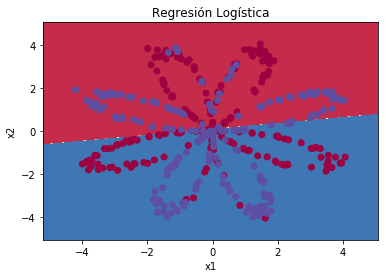

In [63]:
# Dibuja la frontera de desición para la regresión logística.
plot_decision_boundary(lambda x: clf.predict(x), X, Y.ravel())
plt.title("Regresión Logística")

# imprime la exactitud
LR_predictions = clf.predict(X.T)
print ('Exactitud de la regresión logística: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(porcentaje de puntos de datos etiquetados correctamente)")

**Salida Esperada**:

<table style="width:20%">
  <tr>
    <td>**Exactitud**</td>
    <td> 47% </td> 
  </tr>
  
</table>


**Interpretación**: El set de datos no es separable linealmente, entonces la regresión logística no se desempeñará bien. Una red Neuronal debería tener un mejor desempeño.


## 4 - Modelo de una Red Neuronal

Como vimos la regresión logística no se desempeña nada bien en el dataset "flor" al que hemos ajustado el modelo. Ahora vamos a ajustar los datos a un modelo compuesto por una Red Neuronal con una capa escondida.

**Representación esquemática del Modelo**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Representación Matemática**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Dadas las predicciones de todos los ejemplos, podemos computar el costo $J$ como: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Recordatorio**: La metodología general para construir una red neuronal es:
    1. Definir la estructura de la red neuronal ( # numero de entrdadas, # de unidades escondidas, etc).
    2. Inicializar los parametros del modelo.
    3. Bucle:
        - Implementar propagación hacia adelante.
        - Computar las perdidas.
        - Implementar la retropropagación para obtener los gradientes.
        - Actualizar los parametros (Descenso del Gradiente)

Lo ideal es construir funciones de ayuda par computar los pasos 1 a 3 y luego combinar estas funciones en un a funcion mas grande que llamaremos `nn_model()`, Una vez se haya construido `nn_model()` y se hayan aprendido los parametros, se pueden realizar predicciones en nuevos datos.


### 4.1 - Definiendo la estructura de la Red Neuronal ###

**Ejercicio**: Definir tres variables:
    - n_x: El tamaño de la capa de entrada.
    - n_h: El tamaño de la capa oculta (setear este valor a 4)
    - n_y: El tamaño de la capa de salida.

**Pista**: Usar la forma de X y de Y para hallar n_x y n_y. Además, hacer de facto que el tamaño de la capa oculta sea de tamaño = 4


In [64]:

def tamaño_capas(X, Y):
    """
    Argumentos:
    X -- set de datos de entrada de forma (tamaño de entrada, numero de ejemplos)
    Y -- etiquetas de forma (tamaño de salida, numero de ejemplos)
    
    Returns:
    n_x -- tamaño de la capa de entrada
    n_h -- tamaño de la capa oculta
    n_y -- tamaño de la capa de salida
    """
    ### Empezar Código Acá ### (≈ 3 lines of code)
    n_x =  # Tamaño de la capa de entrada
    n_h = 
    n_y =  # Tamaño de la capa de salida
    ### Terminar Código Acá ###
    return (n_x, n_h, n_y)

In [65]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = tamaño_capas(X_assess, Y_assess)
print("El tamaño de la capa de entrada es: n_x = " + str(n_x))
print("El tamaño de la capa oculta es: = " + str(n_h))
print("El tamaño de la capa de salida es: n_y = " + str(n_y))

El tamaño de la capa de entrada es: n_x = 5
El tamaño de la capa oculta es: = 4
El tamaño de la capa de salida es: n_y = 2


**Salida Esperada** (Importante resaltar que estos no son los tamaños que se usarán en la red neuronal, son simplemente valores utilizados para asegurar el funcionamiento de la funcion `tamaño_capas` que se acabó de crear.

<table style="width:20%">
  <tr>
    <td>**n_x**</td>
    <td> 5 </td> 
  </tr>
  
    <tr>
    <td>**n_h**</td>
    <td> 4 </td> 
  </tr>
  
    <tr>
    <td>**n_y**</td>
    <td> 2 </td> 
  </tr>
  
</table>

### 4.2 - Inicializando los parámetros del mdelo ####

**Ejercicio**: Implementar la función `inicializar_parametros()`.

**Instrucciones**:
- Asegurarse de que el tamaño de los parametros es correcto. Referirse a la figura de arriba de ser necesario.
- La matriz de pesos se debe inicializar con valores aleatorios.
    - Usar: `np.random.rand(a,b)*0.01` para inicializar con valores aleatorios una matriz de forma (a,b).
- Inicializar los vectores de bias con ceros.
    - Usar: `np.zeros((a,b))` para inicializar una matriz de forma (a,b) con ceros.

In [66]:

def inicializar_parametros(n_x, n_h, n_y):
    """
    Argumentos:
    n_x -- tamaño de la capa de entrada.
    n_h -- tamaño de la capa oculta.
    n_y -- tamaño de la capa de salida.
    
    Returns:
    parametros -- un diccionario de python que contiene los parametros:
                    W1 -- matriz de pesos de forma (n_h, n_x)
                    b1 -- vector de bias de forma (n_h, 1)
                    W2 -- matriz de pesos de forma (n_y, n_h)
                    b2 -- vector de bias de forma (n_y, 1)
    """
    
    np.random.seed(2) # semilla para que los valores de inicialización sean comprobables..
    
    ### Empezar Código Acá ### (≈ 4 lines of code)
    W1 = 
    b1 = 
    W2 = 
    b2 = 
    ### Codigo Hasta Acá ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parametros = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parametros

In [67]:
n_x, n_h, n_y = initialize_parameters_test_case()

parametros = inicializar_parametros(n_x, n_h, n_y)
print("W1 = " + str(parametros["W1"]))
print("b1 = " + str(parametros["b1"]))
print("W2 = " + str(parametros["W2"]))
print("b2 = " + str(parametros["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


**Salida Esperada**:

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]]</td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>



### 4.3 - El Bucle ####

**Question**: implementar `propagacion_adelante()`.

**Instrucciones**:
- Teniendo en cuenta la representación matemática del clasificador (antes mostrada).
- Podemos usar la función `sigmoid()`. Ya ha sido importda al notebook de trabajo.
- Es posible tambien utilizar la función `np.tanh()`. Es parte de la librería de numpy.
- Los pasos que hay que implementar son:
    1. Tomar cada parametro del diccionario "parametros" (que es la salida de `inicializar_parametros()`) usando la notación `parameters["..""]`.
    2. Implementar la Propagación Hacia Adelante. Computar $Z^{[1]}, A^{[1]}, Z^{[2]}$ y $A^{[2]}$ (el vector de todas las predicciones en todos los ejemplos del set de entrenamiento).
- Los valores que se necesitaran en la retropropagación estarán guardados en "`cache`". El `cache` sera utilizado como entrada en la función de retropropagación.

In [78]:

def propagacion_adelante(X, parametros):
    """
    Argumentos:
    X -- Datos de entrada de tamaño (n_x, m)
    parametros -- diccionario de python conteniendo los parametros (salida de la función de inicialización)
    
    Returns:
    A2 -- Salida sigmoidal de la segunda activación
    cache -- un diccionario que contiene "Z1", "A1", "Z2" and "A2"
    """
    # Tomar cada parametro del diccionario "parametros"
    ### Empezar Código Acá ### (≈ 4 lineas de código)
    W1 = 
    b1 = 
    W2 = 
    b2 = 
    ### Código Hasta Acá ###
    
    # Implementar Propagación Hacia Adelante para calcular A2 (probabilidades)
    ### Empezar Código Acá ### (≈ 4 lines of code)
    Z1 =   # n_h*m
    A1 = 
    Z2 = # n_y*m
    A2 = 
    ### Código Hasta Acá ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [79]:
X_assess, parametros = forward_propagation_test_case()
A2, cache = propagacion_adelante(X_assess, parametros)

# Note: Acá calculamos la media solo para asegurarse de que los valores coincidan con la salida esperada.
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.26281864019752443 0.09199904522700113 -1.3076660128732143 0.21287768171914198


**Salida Esperada**:
<table style="width:50%">
  <tr>
    <td> 0.262818640198 0.091999045227 -1.30766601287 0.212877681719 </td> 
  </tr>
</table>

Ahora que se ha realizado el cálculo de las activaciones $A^{[2]}$ (en la variable de Python "`A2`"), que contiene $a^{[2](i)}$ para cada ejemplo, podemos hacer el computo de la funcion de costo así:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Ejercicio**: Implementar `computo_costo()` para comparar el valor del costo $J$.

**Instrucciones**:
- Hay muchas formas de implementar la pérdida de la entropía cruzada. Para ayudar con la terminología de las librerías de numpy para implementar
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$ acá hay algunos ejemplos:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # no hay necesidad de usar un for loop!
```
(es posible tambien usar `np.multiply()` y luego `np.sum()` o directamente `np.dot()`).


In [70]:

def computo_costo(A2, Y, parametros):
    """
    Realiza el cálculo de la entropía cruzada dada en la ecuación (13)

    Argumentos:
    A2 -- Salida sigmoidal de la segunda activación, de forma (1, número de ejemplos)
    Y --  Vector de Etiquetas "verdaderas" de forma (1, número de ejemplos)
    parametros -- Diccionario de Python conteniendo los prametros W1, b1, W2 and b2
    
    Returns:
    costo -- Entropía cruzada dada en ecuación (13)
    """
    
    m = Y.shape[1] # numero de ejemplos

    # computo de la entropía cruzada
    ### Empezar Código Acá ### (≈ 2 lines of code)
    logprobs = 
    costo =
    ### Código Hasta Acá ###
    
    costo = np.squeeze(costo)     # se asegura de que la dimensión de costo sea la esperada makes sure cost is the dimension we expect. 
                                  # Ejemplo, convierte [[17]] en 17 
    assert(isinstance(costo, float))
    
    return costo

In [71]:
A2, Y_assess, parametros = compute_cost_test_case()

print("costo = " + str(computo_costo(A2, Y_assess, parametros)))

costo = 0.6930587610394646


**Salida Esperada**:
<table style="width:20%">
  <tr>
    <td>**cost**</td>
    <td> 0.693058761... </td> 
  </tr>
  
</table>

Usando la memoria del "cache" calculada durante la propagación hacia adelante, ahora podemos implementar la retropropagación.

**Ejercicio**: implementar la función `retropropagacion()`

**Instrucciones**:
La Retropropagación es usualmente la parte mas compleja (en el contexto matemático) de las redes neuronales. Para tener los conceptos de nomenclatura claros, acá hay un recuento de las 6 ecuaciones utilizadas en el proceso. Es importante notar que dado que se quiere una implementación vectorizada se utilizen las expresiones a la derecha.

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Notar que $*$ se refiere a una multiplicación de elemento a elemento.
- La siguiente notación a usar es común en otras implementaciones de Redes Neuronales:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Pista:
    - para hacer el computo de dZ1 se necesita calcular $g^{[1]'}(Z^{[1]})$. Dado que $g^{[1]}(.)$ es la función de activación de tanh, si $a = g^{[1]}(z)$ entonces $g^{[1]'}(z) = 1-a^2$. asi se podra computar 
    $g^{[1]'}(Z^{[1]})$ usando `(1 - np.power(A1, 2))`.

In [72]:

def retropropagacion(parametros, cache, X, Y):
    """
    Implementa la retropropagación utilizando las instrucciones dadas.
    
    Argumentos:
    parametros -- dicicionario de python que contiene los parámetros
    cache -- diccionario que contiene "Z1", "A1", "Z2" and "A2".
    X -- Datos de entrada de la forma (2, número de ejemplos)
    Y -- Etiquetas verdedar de la forma (1, número de ejemplos)
    
    Returns:
    grads -- diccionario de Python que contiene los gradientes con respecto a diferentes parametros.
    """
    m = X.shape[1]
    
    # Primero, tomar W1 y W2 del diccionario de "parametros".
    ### Empezar Código Acá ### (≈ 2 lines of code)
    W1 =   # nh*nx
    W2 =  # ny*nh
    ### Código Hasta Acá ###
     
    # Tomar tambien A1 y A2 del diccionario "cache".    
    ### Empezar Código Acá ### (≈ 2 lines of code)
    A1 = 
    A2 = 
    ### Código Hasta Acá ###
    
    # Retropropagación: calcular dW1, db1, dW2, db2. 
    ### Empezar Código Acá ### (≈ 6 lines of code, corresponding to 6 equations on slide above)
    dZ2 =    # n_y*m
    dW2 =   # ny*nh
    db2 =  # ny*1
    d_gz = 
    dZ1 =  # nh*m
    dW1 =  # nh*nx
    db1 =  # nh*1
    ### Código hasta Acá ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [73]:
parametros, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = retropropagacion(parametros, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


**Salida Esperada**:



<table style="width:80%">
  <tr>
    <td>**dW1**</td>
    <td> [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]] </td> 
  </tr>
  
  <tr>
    <td>**db1**</td>
    <td>  [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]] </td> 
  </tr>
  
  <tr>
    <td>**dW2**</td>
    <td> [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]] </td> 
  </tr>
  

  <tr>
    <td>**db2**</td>
    <td> [[-0.16655712]] </td> 
  </tr>
  
</table>  

**Ejercicio**: Implementar la regla de la actualización usando el Descenso del Gradiente. Tenemos los gradientes (dW1, db1, dW2, db2) para actualizar (W1, b1, W2, b2).

**Regla General del Descenso del Gradiente**:$ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ donde $\alpha$ es el factor de aprendizaje y $\theta$ representa un parametro.

**Ilustración**: Algorítmo del Descenso del Gradiente con un buen Factor de Aprendizaje (convergiendo) y un mal Factor de Aprendizaje (divergiendo). Imágen cortesía de Adam Harley.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [80]:

def actualizacion_parametros(parametros, grads, learning_rate = 1.2):
    """
    Actualiza los parametros utilizando la regla de actualización del descenso del gradiente dada arriba
    
    Argumentos:
    parametros -- Diccionario de Python que contiene los parámetros 
    grads -- Diccionario de Python que contiene los gradientes 
    
    Returns:
    parametros -- Diccionario de python que contiene los parámetros actualizados 
    """
    
    # Tomar cada parametro del diccionario "parametros"
    ### Empezar Código Acá ### (≈ 4 lines of code)
    W1 = 
    b1 = 
    W2 = 
    b2 = 
    ### Código hasta Acá ###
    
    # Tomar cada gradiente del diccionario "grads
    ### Empezar Código Acá ### (≈ 4 lines of code)
    dW1 = 
    db1 = 
    dW2 = 
    db2 = 
    ## Código Hasta Acá ###
    
    # Regla de actualización para cada parametro
    ### Empezar Código Acá ### (≈ 4 lines of code)
    W1 = 
    b1 = 
    W2 = 
    b2 = 
    ### Código Hasta Acá ###
    
    parametros = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parametros

In [81]:
parametros, grads = update_parameters_test_case()
parametros = actualizacion_parametros(parametros, grads)

print("W1 = " + str(parametros["W1"]))
print("b1 = " + str(parametros["b1"]))
print("W2 = " + str(parametros["W2"]))
print("b2 = " + str(parametros["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


**Expected Output**:


<table style="width:80%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01041081 -0.04463285  0.01758031  0.04747113]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.00010457]] </td> 
  </tr>
  
</table>  

### 4.4 - Integrar las partes 4.1, 4.2 y 4.3 en rn_modelo() ####

**Ejercicio**: Construir el modelo de la red neuronal en la función `rn_modelo()`.

**Instrucciones**: El modelo de la red neuronal tiene que usar las funciones anteriores en el orden correcto.

In [82]:

def rn_modelo(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Argumentos:
    X -- Set de datos de forma(2, número de ejemplos)
    Y -- Etiquetas de forma (1, número de ejemplos)
    n_h -- tamaño de la capa oculta
    num_iterations -- Número de iteraciones en el bucle del Descenso del Gradiente.
    print_cost -- Si es True, imprime el costo cada 1000 iteraciones.
    
    Returns:
    parametros -- parametros aprendidos por el modelo, ahora puede usarse para hacer las predicciones.
    """
    
    np.random.seed(3)
    n_x = tamaño_capas(X, Y)[0]
    n_y = tamaño_capas(X, Y)[2]
    
    # Inicializa los parametros luego obtiene W1, b1, W2, b2. Entradas: "n_x, n_h, n_y". Salidas:"W1, b1, W2, b2, parameters".
    ### Empezar Código Acá ### (≈ 5 lines of code)
    parametros = inicializar_parametros(n_x, n_h, n_y)
    W1 = 
    b1 = 
    W2 = 
    b2 = 
    ### Código Hasta Acá ###
    
    # Bucle (Descenso del Gradiente)

    for i in range(0, num_iterations):
         
        ### Empezar Código Acá ### (≈ 4 lines of code)
        # propagacion_adelante(). Entradas: "X, parameters". Salidas: "A2, cache".
        A2, cache = 
        
        # Funcion de Costo computo_costo(). Entradas: "A2, Y, parametros". Salida: "costo".
        costo = 
 
        # Backpropagation retropropagacion(). Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = 
 
        # actualizacion_parametros(). Inputs: "parameters, grads". Outputs: "parameters".
        parametros = 
        
        ### Código Hasta Acá ###
        
        # Imprime el costo cada 1000 iteraciones
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, costo))

    return parametros

In [83]:
X_assess, Y_assess = nn_model_test_case()
parametros = rn_modelo(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parametros["W1"]))
print("b1 = " + str(parametros["b1"]))
print("W2 = " + str(parametros["W2"]))
print("b2 = " + str(parametros["b2"]))

Cost after iteration 0: 0.692739
Cost after iteration 1000: 0.000218
Cost after iteration 2000: 0.000107
Cost after iteration 3000: 0.000071
Cost after iteration 4000: 0.000053
Cost after iteration 5000: 0.000042
Cost after iteration 6000: 0.000035
Cost after iteration 7000: 0.000030
Cost after iteration 8000: 0.000026
Cost after iteration 9000: 0.000023
W1 = [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 = [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 = [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 = [[0.20459656]]


**Expected Output**:

<table style="width:90%">

<tr> 
    <td> 
        **cost after iteration 0**
    </td>
    <td> 
        0.692739
    </td>
</tr>

<tr> 
    <td> 
        <center> $\vdots$ </center>
    </td>
    <td> 
        <center> $\vdots$ </center>
    </td>
</tr>

  <tr>
    <td>**W1**</td>
    <td> [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-2.45566237 -3.27042274  2.00784958  3.36773273]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.20459656]] </td> 
  </tr>
  
</table>  

### 4.5 Predicciones Predictions

**Ejercicio**: Utilizar el modelo para predecir construyendo la función predecir()
Usar la propagacion hacia adelante para predecir resultados

**Recordar**: predicciones = $y_{prediction} = \mathbb 1 \text{{activación > 0.5}} = \begin{cases}
      1 & \text{if}\ activación > 0.5 \\
      0 & \text{de lo contrario}
    \end{cases}$  
    
Como ejemplo, si que remos setear las entradas de una matriz X a 0 ó a 1 basado en un umbral, haríamos:
```X_new = (X > umbral)```

In [97]:

def predecir(parametros, X):
    """
    Usando los parámetros aprendidos, predecir una clase para cada ejemplo en X
    
    Argumentos:
    parametros -- Diccionario de Python que contiene los parámetros
    X -- Datos de entrada de tamaño(n_x, m)
    
    Returns
    predicciones -- vector de predicciones del modelo (rojo: 0 / azul: 1)
    """
    
    # Computa las probabilidades usando propagacion_adelante() y clasifica como 0/1 usando 0.5 como el umbral
    ### Empezar Código Acá ### (≈ 2 lines of code)
    A2, cache = 
    predicciones = 
    ### Código Hasta Acá ###
    
    return predicciones

In [98]:
parametros, X_assess = predict_test_case()

predicciones = predecir(parametros, X_assess)
print("Media de Predicciones = " + str(np.mean(predicciones)))

Media de Predicciones = 0.6666666666666666


**Salida Esperada**: 


<table style="width:40%">
  <tr>
    <td>**Media de Predicciones**</td>
    <td> 0.666666666667 </td> 
  </tr>
  
</table>

# Corre !! #

Ahora es tiempo de correr el modelo y ver como se desempeña en un dataset plano. Corriendo la siguiente celda de código podremos testear el modelo de una capa oculta de $n_h$ unidades ocultas.

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219471
Cost after iteration 9000: 0.218612


Text(0.5,1,'Decision Boundary for hidden layer size 4')

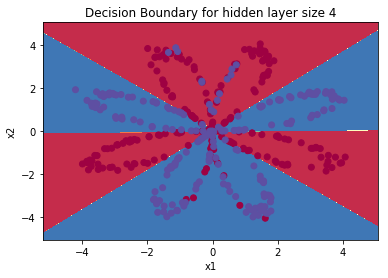

In [101]:
# Construir un modelo con una n_h-dimensional capa oculta
parametros = rn_modelo(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Imprime la frontera de desición
plot_decision_boundary(lambda x: predecir(parametros, x.T), X, Y.ravel())
plt.title("Decision Boundary for hidden layer size " + str(4))

**Salida Esperada**:

<table style="width:40%">
  <tr>
    <td>**Costo luego de la iteración 9000**</td>
    <td> 0.218607 </td> 
  </tr>
  
</table>


In [102]:
# Que tan exacto es el modelo?
predictions = predecir(parametros, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


**Salida Esperada**: 

<table style="width:15%">
  <tr>
    <td>**Exactitud**</td>
    <td> 90% </td> 
  </tr>
</table>

La exactitud es bastante alta, comparada a la regresión logística. el modelo ha reconocido las patrones de hoja de la flor!. Las Redes Neuronales son capaces de aprender incluso fronteras de desición que son no loneales, en un alto grado, esto a diferencia de la regresión logística.

Ahora vamos a intentar con distintos tamaños de capa oculta.


### 4.6 - Configurando el tamaño de la capa oculta ###

Al correr el siguiente código ( que podría tomar 2 minutos) . Observaremos difernetes comportamientos del modelo con varios tamaños de la capa oculta.


Exactitud para 1 unidades ocultas: 67.5 %
Exactitud para 2 unidades ocultas: 67.25 %
Exactitud para 3 unidades ocultas: 90.75 %
Exactitud para 4 unidades ocultas: 90.5 %
Exactitud para 5 unidades ocultas: 91.25 %
Exactitud para 20 unidades ocultas: 90.0 %
Exactitud para 50 unidades ocultas: 90.25 %


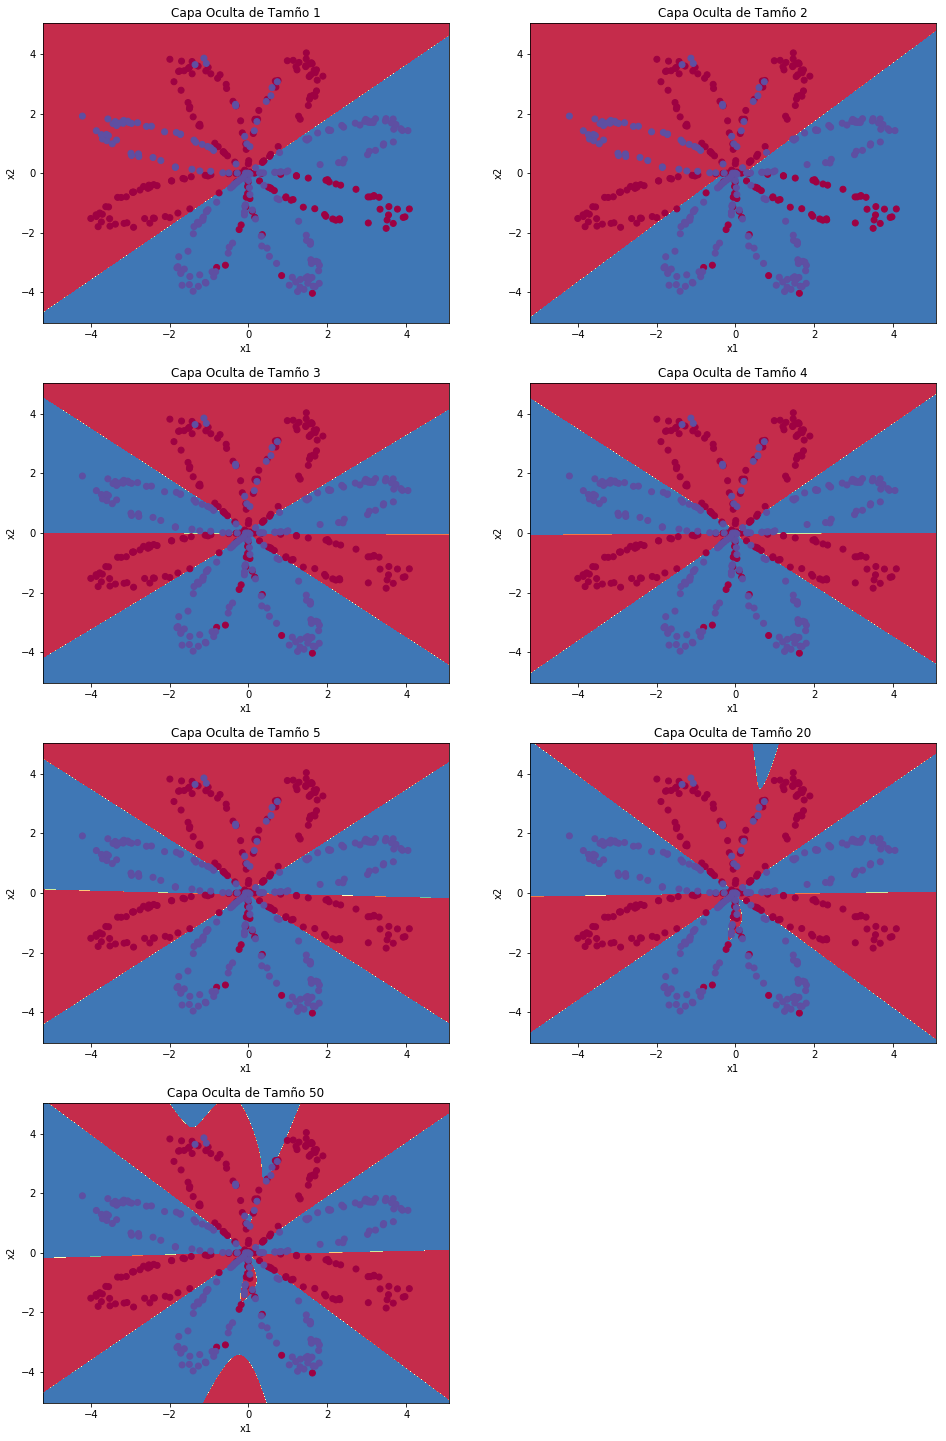

In [105]:
# Puede tomar un par de minutos en correr

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Capa Oculta de Tamño %d' % n_h)
    parameters = rn_modelo(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predecir(parameters, x.T), X, Y.ravel())
    predictions = predecir(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Exactitud para {} unidades ocultas: {} %".format(n_h, accuracy))

**Interpretaciones**:
- Los modelos mas grandes(Con mayor número de unidades ocultas) son capaces de ajustar el set de entrenamiento mejor, hasta que eventualmente los modelos muy grandes sobreajustan los datos.(ocurre Overfitting).
- Los mejores tamaños de la capa oculta parecen ser al rededor de n_h = 5. De hecho un valor de 5 parece ajustar los datos de forma correcta sin incurrir en un notable sobreajuste.
- Existen técnicas para impedir el sobreajuste, conocidas como técnicas de regularización, que son usadas en modelos muy grandes (n_h = 50) para que no tengan este problema.

**Ejercicios Adicionales (Opcionales)**:

Algunas preguntas que permitirán profundizar más sobre redes neuronales.
- Que pasa si cambiamos la función de activación tanh por una función sigmoidal o una activación tipo ReLU(otro tipo de activación, buscar en google)
- Hacer cambios en el Factor de Aprendizaje. Que sucede?
- Que pasa si cambiamos el set de datos? Ver Parte 5.

<font color='blue'>
**Aprendido hasta ahora:**
- Construir una red neuronal completa con una capa oculta.
- Hacer un buen uso de una unidad no-linear
- Implementar la propagación hacia adelante y la retropropagación, y su entrenamiento en una red neuronal.
- Ver el impacto de la variación en el tamaño de la capa oculta, incluyendo el sobreajuste.

Nice work! 

## 5) Desempeño en otros Sets de Datos

Para explorar otros Sets de Datos podemos correr nuevamente todo el notebook, ( a excepcion de la parte del dataset) para cada uno de los siguientes sets de datos.

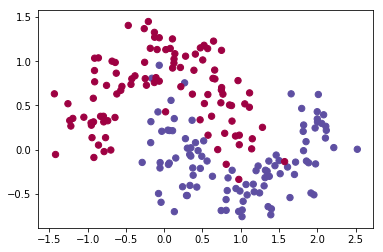

In [107]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### Empezar Código Acá ### (choose your dataset)
dataset = "noisy_moons"
### Código Hasta Acá ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral);

Congrats on finishing this Programming Assignment!

Reference:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/